<a href="https://colab.research.google.com/github/devpathak0212/Land-Cover-Classification/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:

!kaggle datasets download pranjallk1995/rgbeurosat

Dataset URL: https://www.kaggle.com/datasets/pranjallk1995/rgbeurosat
License(s): unknown
 98% 88.0M/89.8M [00:00<00:00, 136MB/s]
100% 89.8M/89.8M [00:00<00:00, 123MB/s]


In [ ]:
!unzip '/content/rgbeurosat.zip'

Streaming output truncated to the last 5000 lines.
  inflating: RBG/train/SeaLake/SeaLake_1112.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1113.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1115.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1116.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1118.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1119.jpg  
  inflating: RBG/train/SeaLake/SeaLake_112.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1120.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1121.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1122.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1123.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1124.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1126.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1127.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1128.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1129.jpg  
  inflating: RBG/train/SeaLake/SeaLake_113.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1130.jpg  
  inflating: RBG/train/SeaLake/SeaLake_1131.jpg  
 

In [ ]:
# Essential and common packages
import os
import glob
import time

# Read and visualize the raster data
# import rasterio
# from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

from tensorflow.keras.models import Sequential

# Tensorflow for building the DenseNet121 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization,
    Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,
    GlobalAveragePooling2D, Dropout
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# For visualization of plots without plt.show()
%matplotlib inline

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2,  # 20% for validation
    rescale=1.0 / 255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:

# Dataset loading and splitting
dataset_url = r'/content/RBG/train'  # Replace with your dataset path
img_height, img_width = 64, 64
batch_size = 32
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)
train_dataset = datagen.flow_from_directory(
    batch_size=batch_size,
    directory=dataset_url,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="training",
    class_mode='categorical'
)
test_dataset = datagen.flow_from_directory(
    batch_size=batch_size,
    directory=dataset_url,
    shuffle=True,
    target_size=(img_height, img_width),
    subset="validation",
    class_mode='categorical'
)


Found 21600 files belonging to 10 classes.
Found 17280 images belonging to 10 classes.
Found 4320 images belonging to 10 classes.


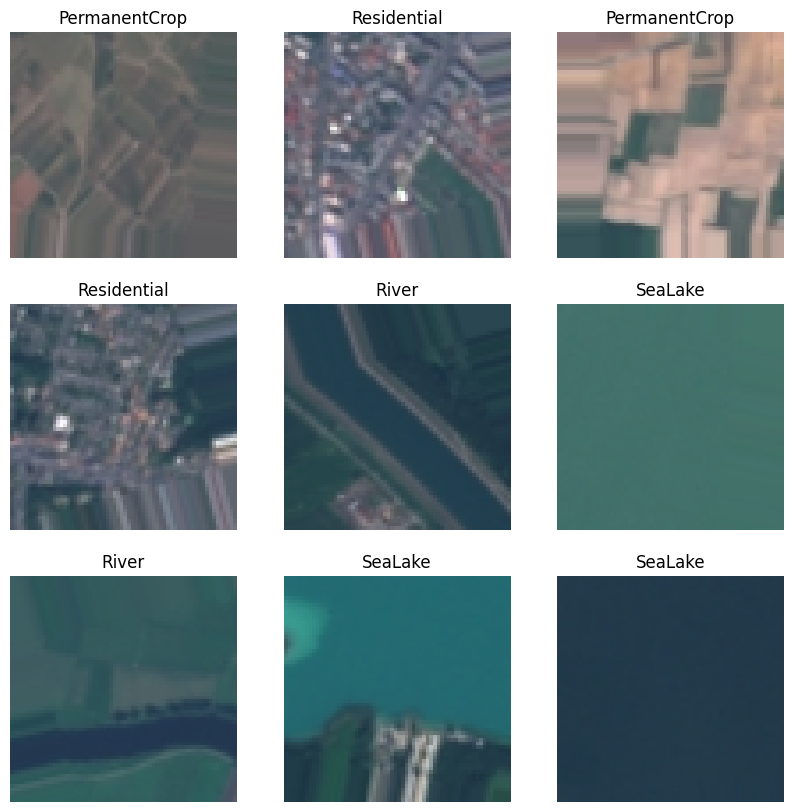

In [ ]:
# Visualizing a few samples from the training dataset
plt.figure(figsize=(10, 10))
class_names = dataset.class_names

for images, labels in train_dataset:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Ensure the image values are in [0, 255] for visualization
        img = images[i] * 255  # Remove .numpy(), as images[i] is already a NumPy array
        img = img.astype("uint8")      # Convert to uint8 for proper display
        plt.imshow(img)
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")
    break

In [ ]:
# Building the model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in base_model.layers[:-5]:  # Freeze all but the last 5 layers
    layer.trainable = False

densenet_model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Number of classes in your dataset
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# Compile the model with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
densenet_model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Adding early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the model
epochs = 100
history = densenet_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


540/540 ━━━━━━━━━━━━━━━━━━━━ 85s 101ms/step - accuracy: 0.5983 - loss: 1.3043 - val_accuracy: 0.8287 - val_loss: 0.5111
Epoch 2/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 44s 80ms/step - accuracy: 0.7714 - loss: 0.6840 - val_accuracy: 0.8539 - val_loss: 0.4378
Epoch 3/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 81s 79ms/step - accuracy: 0.8129 - loss: 0.5670 - val_accuracy: 0.8667 - val_loss: 0.3944
Epoch 4/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 84s 83ms/step - accuracy: 0.8298 - loss: 0.5062 - val_accuracy: 0.8708 - val_loss: 0.3654
Epoch 5/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 80s 79ms/step - accuracy: 0.8371 - loss: 0.4804 - val_accuracy: 0.8829 - val_loss: 0.3326
Epoch 6/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.8437 - loss: 0.4630 - val_accuracy: 0.8822 - val_loss: 0.3285
Epoch 7/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.8539 - loss: 0.4405 - val_accuracy: 0.8884 - val_loss: 0.3272
Epoch 8/100
540/540 ━━━━━━━━━━━━━━━━━━━━ 44s 81ms/step - accuracy: 0.8506 - loss: 0.4340 - val

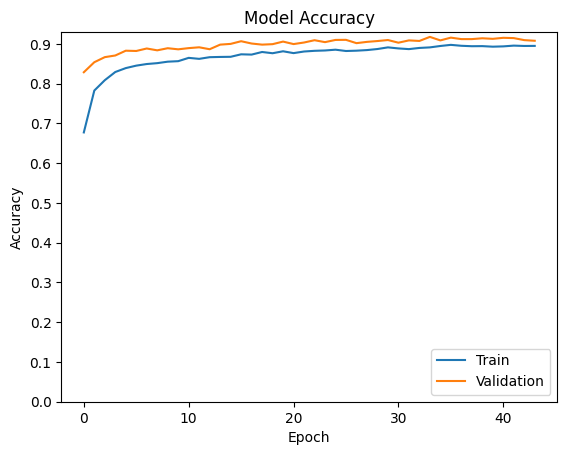

In [ ]:
import matplotlib.ticker as ticker
# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(ymin=0.0)
plt.legend(['Train', 'Validation'], loc='lower right')
loc = ticker.MultipleLocator(base=0.1)
plt.gca().yaxis.set_major_locator(loc)
plt.savefig('model_accuracy.png', dpi=300)
plt.show()

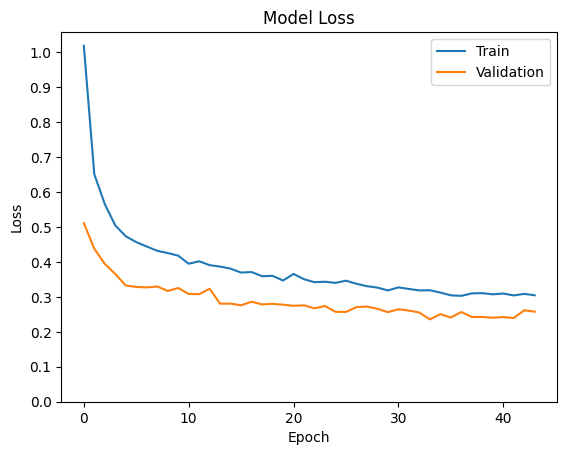

In [ ]:
import matplotlib.ticker as ticker
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(ymin=0.0)
plt.legend(['Train', 'Validation'], loc='upper right')
loc = ticker.MultipleLocator(base=0.1)
plt.gca().yaxis.set_major_locator(loc)
plt.savefig('model_loss.png', dpi=300)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━

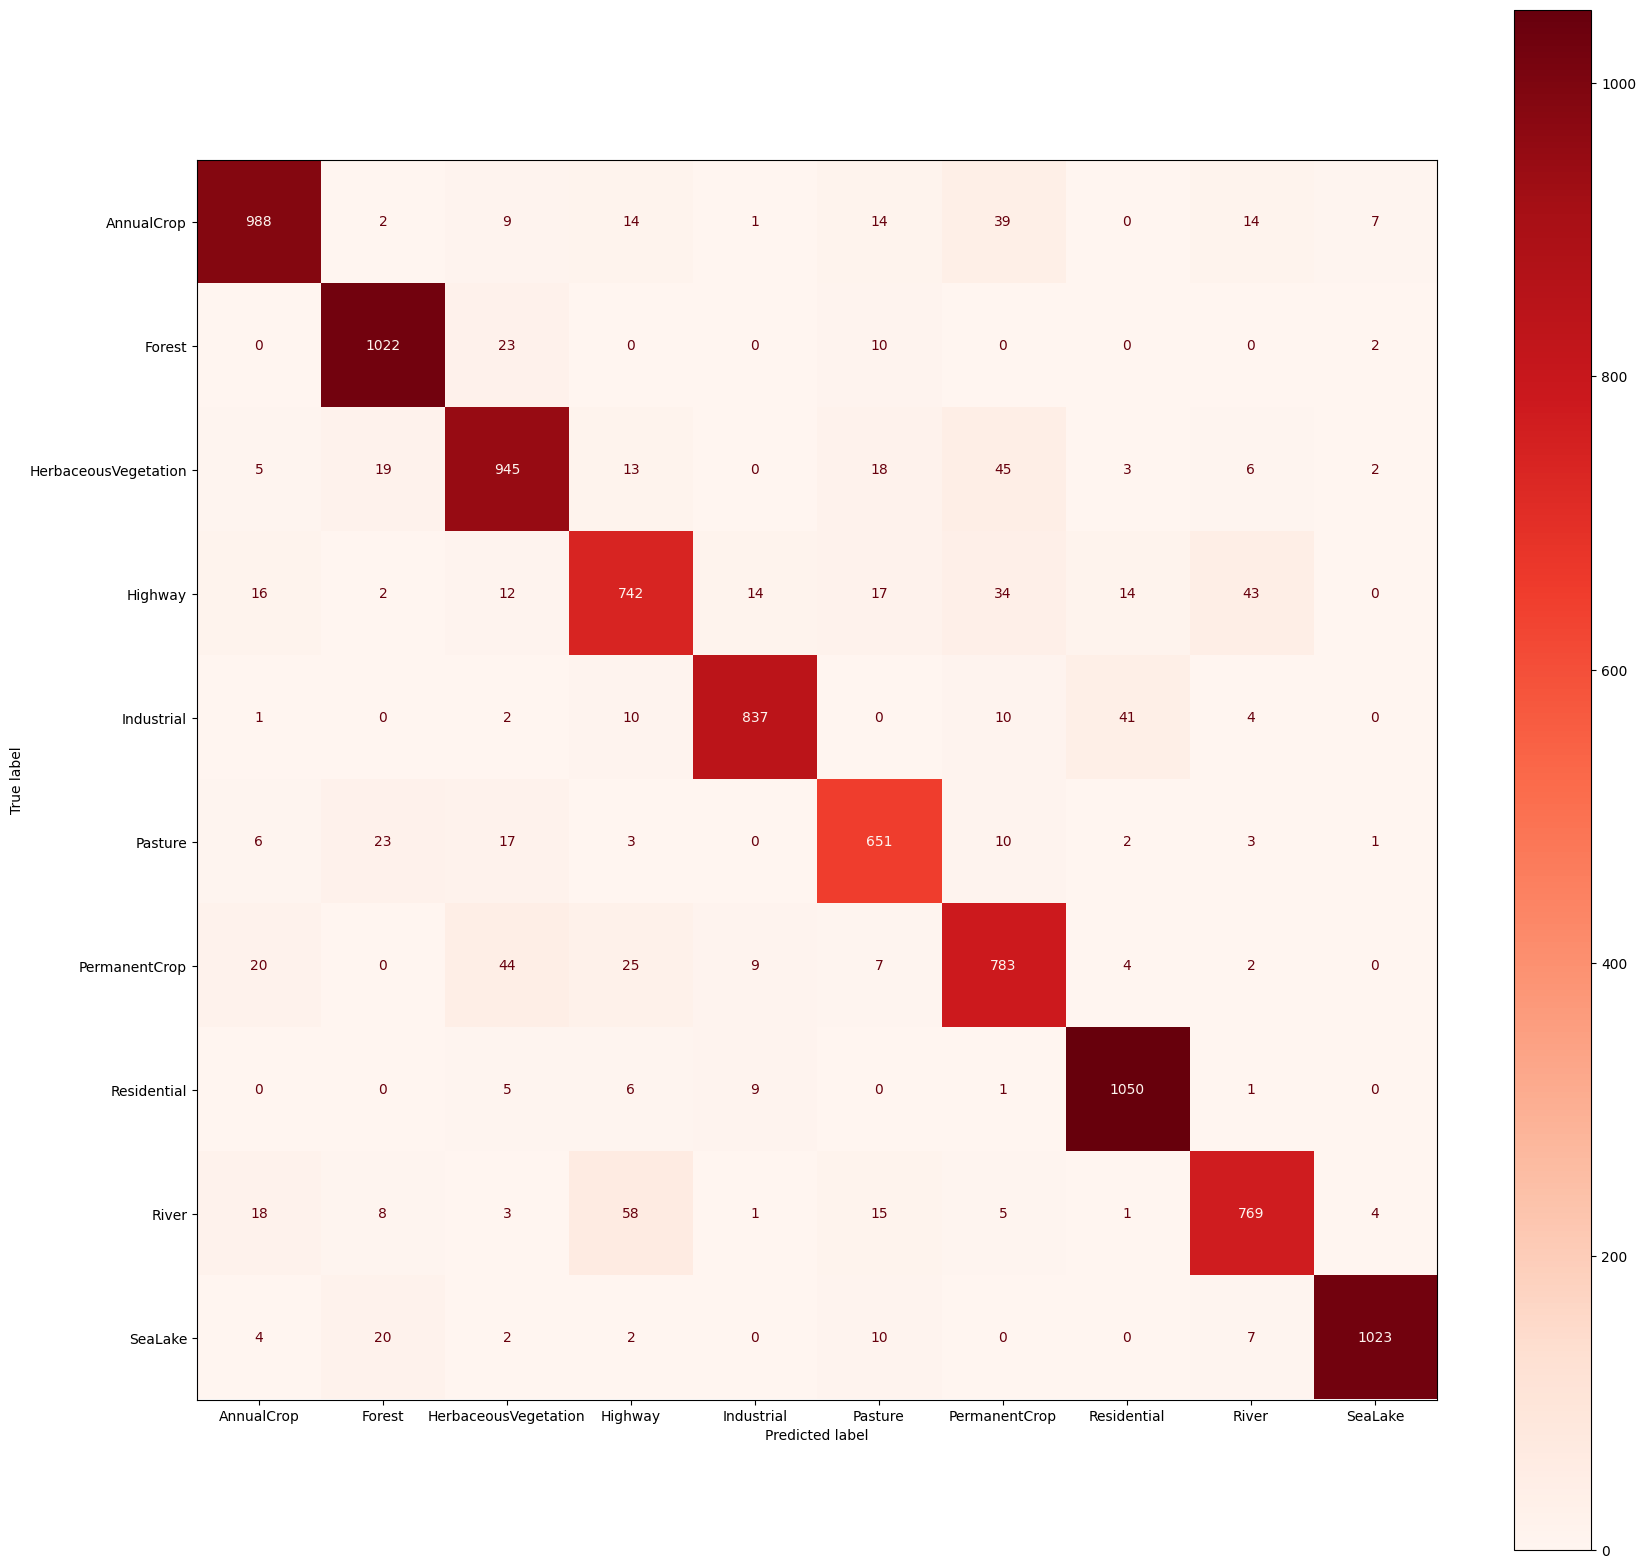

In [ ]:
# Evaluate the model and visualize confusion matrix
y_pred = []
y_true = []

for i, (image_batch, label_batch) in enumerate(test_dataset):
    y_true.append(label_batch)
    preds = densenet_model.predict(image_batch)
    y_pred.append(np.argmax(preds, axis=1))
    if i == 300:
        break

correct_labels = tf.concat([item for item in y_true], axis=0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
cm = confusion_matrix(correct_labels, predicted_labels)

fig, ax = plt.subplots(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names))
disp.plot(ax=ax, cmap='Reds')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [ ]:
# Classification report
report = classification_report(correct_labels, predicted_labels, target_names=list(class_names))
print(report)

# Save the model
densenet_model.save('densenet121_model.h5')
model_size = os.path.getsize('densenet121_model.h5')
print(f"Model Size: {model_size} bytes ({model_size / (1024 * 1024):.2f} MB)")

# Measure inference time
start_time = time.time()
predictions = densenet_model.predict(test_dataset)
end_time = time.time()
print(f"Inference Time: {end_time - start_time:.2f} seconds")

# Model summary and parameter count
densenet_model.summary()
total_params = densenet_model.count_params()
print(f"Total Trainable Parameters: {total_params}")

                      precision    recall  f1-score   support

          AnnualCrop       0.93      0.91      0.92      1088
              Forest       0.93      0.97      0.95      1057
HerbaceousVegetation       0.89      0.89      0.89      1056
             Highway       0.85      0.83      0.84       894
          Industrial       0.96      0.92      0.94       905
             Pasture       0.88      0.91      0.89       716
       PermanentCrop       0.84      0.88      0.86       894
         Residential       0.94      0.98      0.96      1072
               River       0.91      0.87      0.89       882
             SeaLake       0.98      0.96      0.97      1068

            accuracy                           0.91      9632
           macro avg       0.91      0.91      0.91      9632
        weighted avg       0.92      0.91      0.91      9632

Model Size: 56156240 bytes (53.55 MB)
135/135 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step
Inference Time: 15.74 seconds


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 2, 2, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,816,159 (52.70 MB)

 Trainable params: 2,272,010 (8.67 MB)

 Non-trainable params: 7,000,128 (26.70 MB)

 Optimizer params: 4,544,021 (17.33 MB)

Total Trainable Parameters: 9272138
